> This kernel and all of idea in it are a copy of [Conditional_Generative_Adversarial_Network - by Arpan Dhatt](https://www.kaggle.com/arpandhatt/conditional-generative-adversarial-network).
Thank you for nice reference

# Conditional GAN

In a CGAN, you can specify a condition that the generated image has to adhere to. 
If you were to do this with MNIST, you can choose which label you would like to use to generate an image. This is extremely powerful when you are trying to create images of a certain type. 

As long as you have labels, you can choose what type of image to create. For example, you could use the CelebA dataset which supplies a picture of a celebrity plus sum attributes which you could use as a set of conditions. Then you could say you want an image of a male actor with sunglasses, etc. We will make a simple CGAN for the MNIST:

In [1]:
# Get some packages
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from skimage.io import imshow
import time
import random

# Basic Concept
![image](https://i.pinimg.com/736x/05/75/ca/0575cab5214b55e99a59f0b64c35e1c5--arches.jpg)

As you can see, it's very simple. When we generate an image, we input the noize `z` concatenated with the conditions `c`. When we use the discriminator, we concatenate the generated image withe the `c` we used to generate it. If we are showing a real example, we add the condition, `c` with it. 

We are going to use PyTorch for this demo. This way, I can get into more detail than I could have using Keras. As always, let's download and view the data first:

> index
```
Step 1. Load Data
     1-a. read csv
     1-b. x & y split
     1-c. data preprocessing - x
     1-d. data preprocessing - y 
     1-e. show sample image
Step 2. Modeling
     2-a. generator network
     2-b. discriminator network
     3-c. instantiate the networks
     3-d. moving the networks to the gpu
     3-e. create the loss function and optimizers
     3-f. creating network optimizing functions 
Step 3. Model Training
```


## Step 1. Load Data

### 1-a. read csv

In [2]:
# Read CSV
csv = pd.read_csv('../input/digit-recognizer/train.csv')

In [3]:
csv

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1-b. X & Y Split

In [4]:
# Separate into metrices
X_train = csv.iloc[:, 1:].to_numpy()
Y_train = csv.iloc[:,0].to_numpy()

In [5]:
X_train.shape

(42000, 784)

In [6]:
Y_train.shape

(42000,)

### 1-c. Data Preprocessing - X

In [7]:
count_imgs = X_train.shape[0] # 42000

In [8]:
X_train_imgs = np.zeros([42000, 1, 28, 28])
for i in range(count_imgs):
    img = X_train[i,:].reshape([1,28,28])/255. # reshape & normalize
    X_train_imgs[i] = img

### 1-d. Data Preprocessing - Y

In [9]:
Y_train_oh = np.zeros([42000,10]) # 42000 rows * 10 columns(filled with 0.)
for i in range(count_imgs):
    oh = np.zeros([10]) # array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    oh[int(Y_train[i])] = 1. # one-hot encoded Y vector(1 row)
    Y_train_oh[i] = oh # fill one-hot encoded Y vector to Y_trian_oh matrix

In [10]:
X_train_imgs[0].shape

(1, 28, 28)

In [11]:
np.squeeze(X_train_imgs[0]).shape

(28, 28)

### 1-e. show sample image

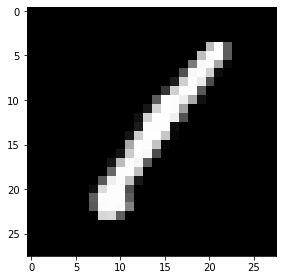

This is : 1


In [12]:
sample_img = np.squeeze(X_train_imgs[0]) # (1,28,28) --(squeeze)--> (28,28)
imshow(sample_img)
plt.show()
print('This is : {}'.format(Y_train[0]))

# Tricks on Training GANs

GANs are notoriously hard to train. Since we are using 2 neural networks, we need to make sure they are balaced. That is ONE of the problems. Another is mode collapse, where the generator doesn't produce images with lots of variety. This can get problematic, so we try to employ some tricks to keep the GANs balanced:

1. Sample from a normal distribution, not a uniform one
2. Normalize images between -1 and 1, not 1 and 0
3. Use `max log D` instead of `min(log 1 - D)` as a loss to train the Generator
4. Construct whole mini-batches of real and generated images, not a mix
5. Use LeakyReLU not ReLU
6. Use ConvTranspose2D instead of Upsampling
7. Use Label Smooting

We will also add a more complex set of variables that will be returned when training. Not only will we return the `G`and `D` loss, but also the `D`'s variance. We want the variance to stay low in the discriminator loss, so we will keep track of it.

**Note**: We will be using a Deep Convolutional GAN for it's superior performance!
![image](https://i2.wp.com/kawahara.ca/wp-content/uploads/unsupervised_representation_learning_with_DCGAN.png)

## Step 2. Modeling

### 2-a. Generator Network

In [13]:
class _G(nn.Module):
    def __init__(self, z_size, c_size):
        super(_G, self).__init__()
        
        self.conv2dtranspose_z = nn.ConvTranspose2d(in_channels=z_size, out_channels=256, kernel_size=4, stride=1)
        self.bn2d_z = nn.BatchNorm2d(256, momentum=0.9)
        self.conv2dtranspose_c = nn.ConvTranspose2d(in_channels=c_size, out_channels=256, kernel_size=4, stride=1)
        self.bn2d_c = nn.BatchNorm2d(256, momentum=0.9)
        self.backbone = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=2, stride=2, padding=2),
            nn.Tanh()
        )
        
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, z, c):
        z = z.view(-1, 100, 1, 1)
        z = self.conv2dtranspose_z(z)
        z = self.bn2d_z(z)
        z = F.leaky_relu(z)
        
        c = c.view(-1, 10, 1, 1)
        c = self.conv2dtranspose_c(c)
        c = self.bn2d_c(c)
        c = F.leaky_relu(c)
        
        zc = torch.cat([z,c],dim=1)
        output = self.backbone(zc)
        return output
    

### 2-b. Disciminator Network

In [14]:
class _D(nn.Module):
    def __init__(self, c_size):
        super(_D, self).__init__()
        
        self.conv2d_x = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv2d_c = nn.Conv2d(in_channels=10, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1 ),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(512, momentum=0.9),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=3, stride=2),
            nn.Sigmoid()
        )
        
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x, c):
        x = self.conv2d_x(x)
        
        c = c.view(-1, 10, 1, 1)
        c = c.expand(-1, 10, 28, 28)
        c = self.conv2d_c(c)
        
        xc = torch.cat([x,c], dim=1)
        output = self.backbone(xc)
        output = output.view(-1,1)
        return output

### 2-c. Instantiate the Networks

In [15]:
G = _G(100, 10) # Noise vector will have size 100
                # and wee will have a condition vector of 10(1 for each type of item)
D = _D(10) # The Discriminator will also use the condition,
           # So we say it has size 10

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

G.weight_init(mean=0, std=0.2) # GAN works better with these wight initializations
D.weight_init(mean=0, std=0.2)

### 2-d. Moving the networks to the GPU

Unlike Keras, we have to move the network to the GPU manually. PyTorch doesn't do this automatically. This is because it allows you to construct a complex multithreaded data feeder. This gist is that PyTorch gives you a lot more flexibility than Keras. It is also nearly twice as fast and extremely memory efficient.

In [16]:
if torch.cuda.is_available():
    print('Current device : GPU - cuda:{}'.format(torch.cuda.current_device()))
    print('\n-------------------------------')
    print('G.cuda() :\n')
    print(G.cuda())
    print('\n-------------------------------')
    print('D.cuda() :\n')
    print(D.cuda())
else:
    print('Current device : CPU')

Current device : GPU - cuda:0

-------------------------------
G.cuda() :

_G(
  (conv2dtranspose_z): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
  (bn2d_z): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (conv2dtranspose_c): ConvTranspose2d(10, 256, kernel_size=(4, 4), stride=(1, 1))
  (bn2d_c): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (backbone): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(128, 1, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
    (7): Tanh()
  )
)

-----

### 2-e. Creating the Loss Function and Optimizers

In [17]:
# 1. Creating Loss Function
criterion = nn.BCELoss() # Binary Cross-Entropy Loss

# 2. Creating Optimizers
optim_G = optim.Adam(G.parameters(), lr=0.0002)
optim_D = optim.Adam(D.parameters(), lr=0.0002)

# Now let's create two functions for optimizing each network

I'm going this to simplify the process. Let's start with the optimization function:

### 2-f. Creating Network Optimizing Functions - Network : G

In [18]:
def optimize_G(G, D, z, c, optimizer, criterion):
    
    """
    When we train the generator we want it to trick the discriminator. This means that we want the output of D to be close to 1,
    meaning it thinks its real. Keep that in mind. When we train G, we make the fake labels equal 1 so the optimizer tried to
    make the generator make an image that tricks D.
    """
    
    #Even though the images are fake, we want the discriminator to think they are real
    trick_labels = Variable(torch.ones([z.shape[0],1])-torch.rand([z.shape[0],1])/3).cuda()
    #Zero gradient buffers
    G.zero_grad()
    #Generate Images
    fake_x = G.forward(z, c)
    D_preds = D(fake_x, c)
    loss = criterion(D_preds, trick_labels)
    loss.backward()
    optimizer.step()
    
    return fake_x, loss

### 2-g. Creating Network Optimizing Functions - Network : D

In [19]:
def optimize_D(net, fake_x, fake_c, real_x, real_c, optimizer, criterion):
    # We cannot feed a numpy variable. We have to use a torch.autograd.Variable
    fake_labels = Variable(torch.zeros([fake_x.shape[0],1]) + torch.rand([z.shape[0],1])/3).cuda()
    real_labels = Variable(torch.ones([real_x.shape[0],1]) - torch.rand([z.shape[0],1])/3).cuda()
    
    # We need to empty the gradient buffers
    net.zero_grad()
    
    # Let's get the discriminator predictions for the fake images
    fake_preds = net.forward(fake_x.detach(), fake_c)
    # Do the optimization
    fake_loss = criterion(fake_preds, fake_labels)
    # Let's get the discriminator predictions for the real images
    real_preds = net.forward(real_x, real_c)
    # Do the optimization
    real_loss = criterion(real_preds, real_labels)
    
    loss = fake_loss + real_loss
    loss.backward()
    optimizer.step()
    
    return fake_loss + real_loss

# Now let's start the training

Lets lay out the plan to the code we will use for training:

1. Sample `z` from a Gaussian Distribution
2. Create a batch of condition `c`
3. Optimize `G`
4. Optimize `D`
5. Repeat

## Step 3. Model Training

(280, 280)


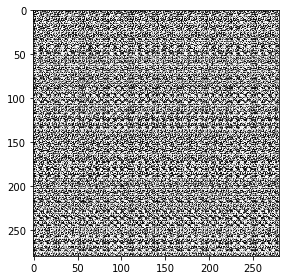

G loss :  0.7906631231307983
D loss :  1.3658770322799683
D loss variance :  0.0
(280, 280)


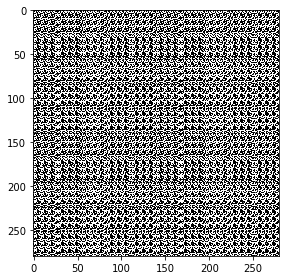

G loss :  1.0412732362747192
D loss :  1.0446889400482178
D loss variance :  0.30544325153586926
(280, 280)


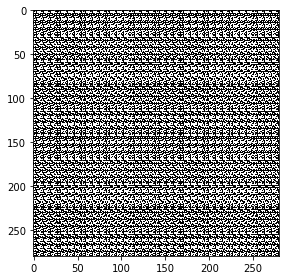

G loss :  1.5805779695510864
D loss :  0.9360007047653198
D loss variance :  0.2380060750694673
(280, 280)


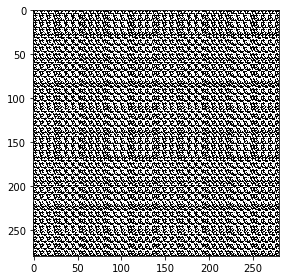

G loss :  1.0622227191925049
D loss :  0.9702821969985962
D loss variance :  0.2000486610472815
(280, 280)


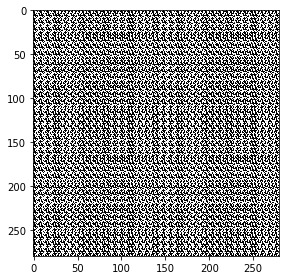

G loss :  1.0052211284637451
D loss :  0.945214569568634
D loss variance :  0.17596504479493988
(280, 280)


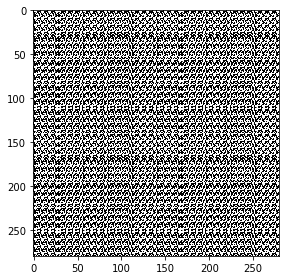

G loss :  1.264730453491211
D loss :  0.9382181167602539
D loss variance :  0.15984846817797968
(280, 280)


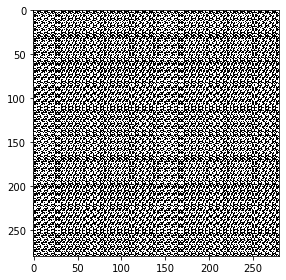

G loss :  1.3532934188842773
D loss :  0.8910691738128662
D loss variance :  0.14794925443413384
(280, 280)


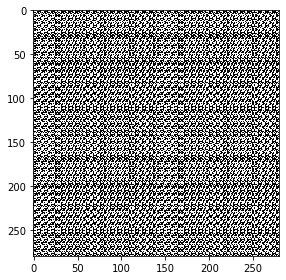

G loss :  1.5232216119766235
D loss :  0.9083350300788879
D loss variance :  0.13840837632946917
(280, 280)


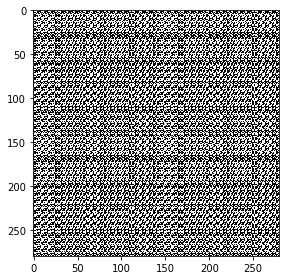

G loss :  1.5909836292266846
D loss :  0.9209291934967041
D loss variance :  0.13060675070878333
(280, 280)


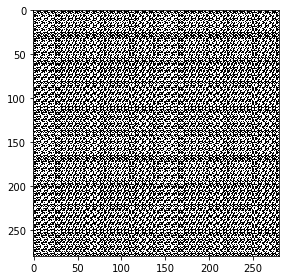

G loss :  1.5141949653625488
D loss :  0.9039296507835388
D loss variance :  0.1241679457332223
(280, 280)


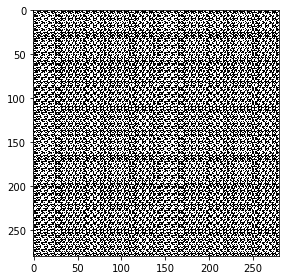

G loss :  1.517754077911377
D loss :  0.8868805170059204
D loss variance :  0.11846786992312974
(280, 280)


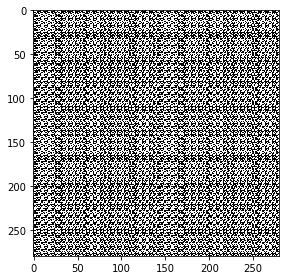

G loss :  1.4265509843826294
D loss :  0.9350917339324951
D loss variance :  0.11362052413835029
(280, 280)


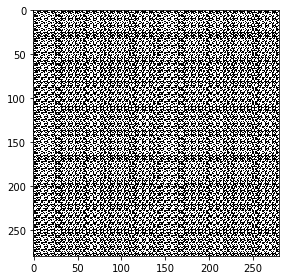

G loss :  1.4663182497024536
D loss :  0.9109258055686951
D loss variance :  0.10924220742679436
(280, 280)


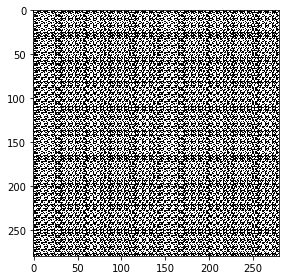

G loss :  1.5338670015335083
D loss :  0.924278736114502
D loss variance :  0.105312736863468
Finished Epoch 1
(280, 280)


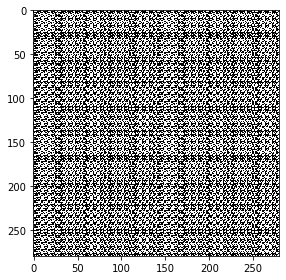

G loss :  1.5417126417160034
D loss :  0.8932932615280151
D loss variance :  0.10491093039099712
(280, 280)


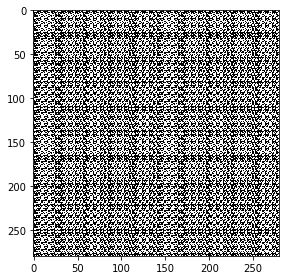

G loss :  1.560937762260437
D loss :  0.8731136918067932
D loss variance :  0.10153878342295329
(280, 280)


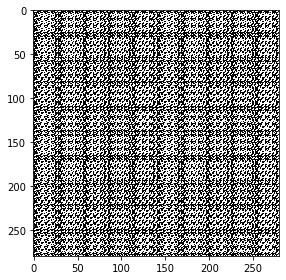

G loss :  1.509996771812439
D loss :  0.912972629070282
D loss variance :  0.09835372428373401
(280, 280)


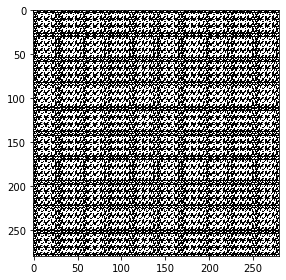

G loss :  1.606797695159912
D loss :  0.868329644203186
D loss variance :  0.09550246274804397
(280, 280)


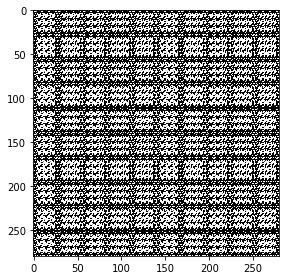

G loss :  1.5024961233139038
D loss :  0.9009714126586914
D loss variance :  0.09281070880915201
(280, 280)


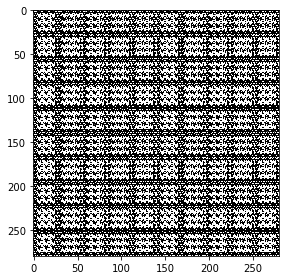

G loss :  1.5392415523529053
D loss :  0.9039664268493652
D loss variance :  0.09053638742012733
(280, 280)


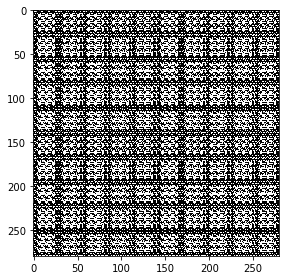

G loss :  1.5251492261886597
D loss :  0.9608747959136963
D loss variance :  0.08834561930739954
(280, 280)


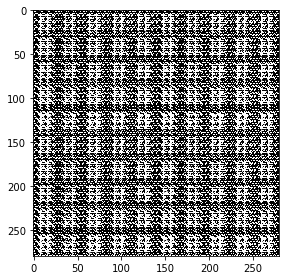

G loss :  1.4806113243103027
D loss :  0.9417593479156494
D loss variance :  0.08632927944446635
(280, 280)


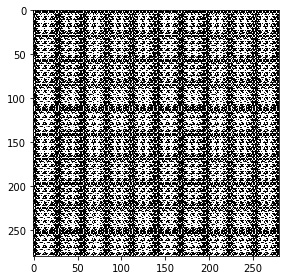

G loss :  1.4714405536651611
D loss :  0.9383337497711182
D loss variance :  0.08439298329727524
(280, 280)


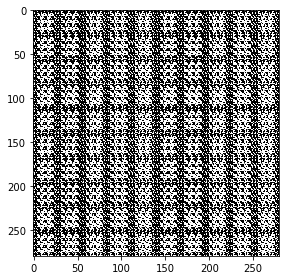

G loss :  1.3473618030548096
D loss :  0.9350149631500244
D loss variance :  0.0826064580101661
(280, 280)


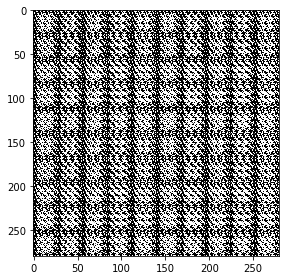

G loss :  1.520068883895874
D loss :  0.8856626749038696
D loss variance :  0.08100068301474826
(280, 280)


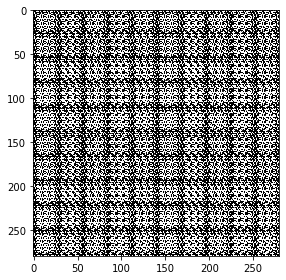

G loss :  1.3298671245574951
D loss :  0.9155279397964478
D loss variance :  0.07943860045544056
(280, 280)


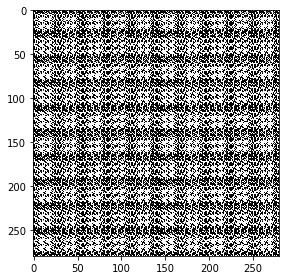

G loss :  1.416231632232666
D loss :  0.9119813442230225
D loss variance :  0.07796921605256814
(280, 280)


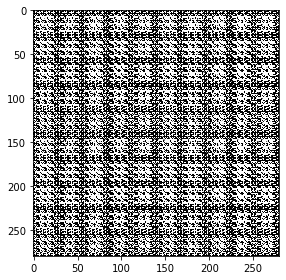

G loss :  1.5618765354156494
D loss :  0.8840028047561646
D loss variance :  0.07658719140384727
Finished Epoch 2
(280, 280)


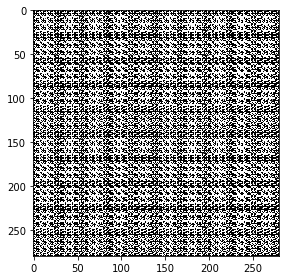

G loss :  1.5294989347457886
D loss :  0.9212054014205933
D loss variance :  0.07641819703929889
(280, 280)


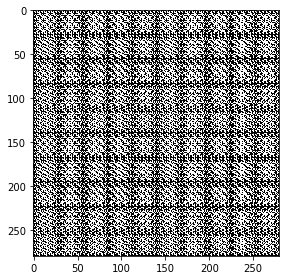

G loss :  1.4882242679595947
D loss :  0.9361445903778076
D loss variance :  0.07522313027897988
(280, 280)


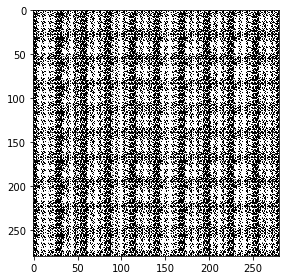

G loss :  1.3419103622436523
D loss :  0.9551573991775513
D loss variance :  0.07401802474186152
(280, 280)


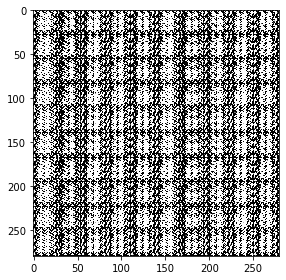

G loss :  1.6170985698699951
D loss :  0.9028488397598267
D loss variance :  0.0728484210117922
(280, 280)


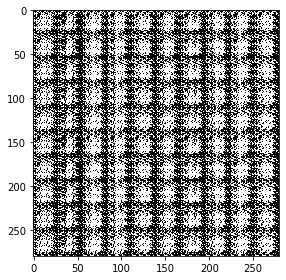

G loss :  1.5953021049499512
D loss :  0.9362168312072754
D loss variance :  0.07174803088109565
(280, 280)


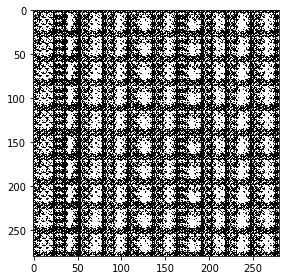

G loss :  1.5749685764312744
D loss :  0.931814432144165
D loss variance :  0.07081916017408411
(280, 280)


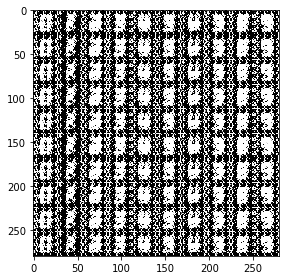

G loss :  1.6067776679992676
D loss :  0.9210887551307678
D loss variance :  0.06990462553443817
(280, 280)


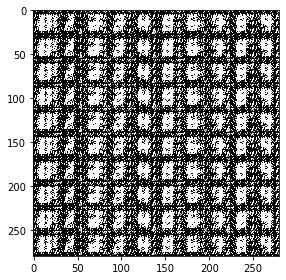

G loss :  1.4539523124694824
D loss :  0.908455491065979
D loss variance :  0.06895355218559848
(280, 280)


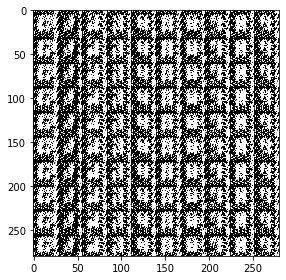

G loss :  1.7406810522079468
D loss :  0.9317551851272583
D loss variance :  0.06801678283911958
(280, 280)


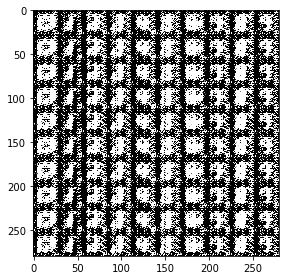

G loss :  1.5278968811035156
D loss :  0.9277268648147583
D loss variance :  0.06713923497207464
(280, 280)


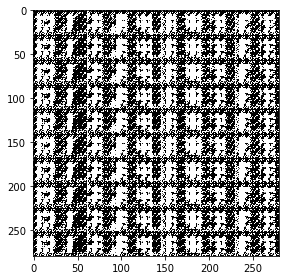

G loss :  1.634342908859253
D loss :  0.939691424369812
D loss variance :  0.0663032487271515
(280, 280)


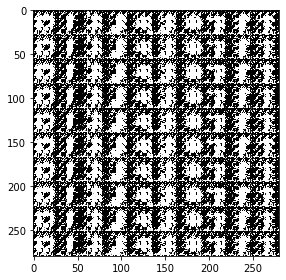

G loss :  1.4571059942245483
D loss :  0.8968658447265625
D loss variance :  0.06549992873253568
(280, 280)


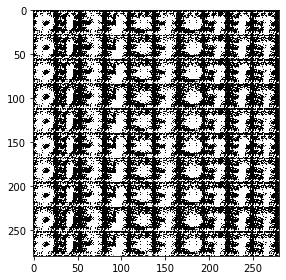

G loss :  1.5404963493347168
D loss :  0.8905312418937683
D loss variance :  0.06476294828870544
(280, 280)


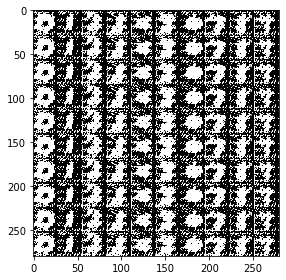

G loss :  1.5268255472183228
D loss :  0.930910587310791
D loss variance :  0.06402423402395117
Finished Epoch 3


In [24]:
D_history = []
G_history = []
EPOCHS = 3 # for test, just 3 epochs.
BATCH_SIZE = 128

for epoch in range(EPOCHS):
    train_loss = 0
    speed = 0
    for batch_number in range(int(Y_train.shape[0]/BATCH_SIZE)):
        G.train()
        time_start = time.time()
        real_x = Variable(torch.FloatTensor(X_train_imgs[batch_number*BATCH_SIZE:(1+batch_number)*BATCH_SIZE])).cuda()
        real_x = (real_x - real_x.mean())/real_x.std() # Standardization
        real_c = Variable(torch.FloatTensor(Y_train_oh[batch_number*BATCH_SIZE:(1+batch_number)*BATCH_SIZE])).cuda()
        
        z = Variable(torch.FloatTensor(np.random.randn(BATCH_SIZE, 100))).cuda()
        fake_x, loss = optimize_G(G,D,z,real_c,optim_G,criterion)
        G_history.append(loss.data.cpu().numpy().item())
        
        loss = optimize_D(D,fake_x,real_c,real_x,real_c,optim_D,criterion)
        D_history.append(loss.data.cpu().numpy().item())
        
        if batch_number % 25 == 0:
            bigfig = []
            for i in range(0,10):
                z = np.random.randn(1,100)
                z = torch.FloatTensor(z)
                z = Variable(z).cuda()
                G.eval()
                fig = []
                for i in range(0,10):
                    c = np.zeros([1,10])
                    c[0,i] = 1.
                    c = torch.FloatTensor(c)
                    c = Variable(c).cuda()
                    gens = G.forward(z, c)
                    gens = gens.data.cpu().numpy()
                    gens = gens.reshape([28,28])
                    fig.append(gens/2+0.5)
                fig = np.hstack(fig)
                bigfig.append(fig)
            bigfig = np.vstack(bigfig)
            print (bigfig.shape)
            imshow(bigfig)
            plt.show()
            
            print('G loss : ', G_history[-1])
            print('D loss : ', D_history[-1])
            print('D loss variance : ', np.stack(D_history, axis=0).std())
    print('Finished Epoch', epoch+1)